<div style="display: flex; align-items: center;">
    <h1>Optimizing parameters in a WOFOST crop model using <code>diffWOFOST</code></h1>
    <img src="https://raw.githubusercontent.com/WUR-AI/diffWOFOST/refs/heads/main/docs/logo/diffwofost.png" width="150" style="margin-left: 20px;">
</div>


This Jupyter notebook demonstrates the optimization of parameters in a
differentiable model using the `diffwofost` package. The package provides
differentiable implementations of the WOFOST model and its associated
sub-models. As `diffwofost` is under active development, this notebook focuses on
`partitioning`. 

To enable these models to operate independently, certain state variables
required by the model are supplied as "external states" derived from the test
data. Also, at this stage, only a limited subset of model parameters has been made
differentiable.

## 1. Partitioning

In this section, we will demonstrate how to optimize parameters `FLTB`, `FSTB`, and `FOTB` in
partitioning model using a differentiable version of partitioning. We skip the parameters `FRTB`. 
The optimization will be done using the Adam optimizer from `torch.optim`.

### 1.1 software requirements

To run this notebook, we need to install the `diffwofost`; the differentiable
version of WOFOST models. Since the package is constantly under development, make
sure you have the latest version of `diffwofost` installed in your
python environment. You can install it using pip:

In [ ]:
# install diffwofost
!pip install diffwofost

In [1]:
# ---- import libraries ----
import copy
import torch
import numpy
import yaml
from pathlib import Path
from diffwofost.physical_models.config import Configuration
from diffwofost.physical_models.crop.partitioning import DVS_Partitioning
from diffwofost.physical_models.utils import EngineTestHelper
from diffwofost.physical_models.utils import prepare_engine_input
from diffwofost.physical_models.utils import get_test_data

In [2]:
# --- run on CPU ------
from diffwofost.physical_models.config import ComputeConfig
ComputeConfig.set_device('cpu')

In [3]:
# ---- disable a warning: this will be fixed in the future ----
import warnings
warnings.filterwarnings("ignore", message="To copy construct from a tensor.*")

### 1.2. Data

A test dataset of `FR` (Fraction partitioned to roots),
`FL` (Fraction partitioned to leaves), `FS` (Fraction partitioned to stems), 
`FO` (Fraction partitioned to storage organs) will be used to optimize
parametesr `FRTB` (Partitioning to roots), `FLTB` (Partitioning to leaves),
`FSTB` (Partitioning to stems), and `FOTB` (Partitioning to storage).
Note that in partitioning, changes in `FRTB` affect `FR`, in `FLTB` affect `FL` and so on. 

The data is stored in PCSE tests folder, and can be doewnloded from PCSE repsository.
You can select any of the files related to `partitioning` model with a file name that follwos the pattern
`test_partitioning_wofost72_*.yaml`. Each file contains different data depending on the locatin and crop type.
For example, you can download the file "test_partitioning_wofost72_01.yaml" as:

In [4]:
import urllib.request

url = "https://raw.githubusercontent.com/ajwdewit/pcse/refs/heads/master/tests/test_data/test_partitioning_wofost72_01.yaml"
filename = "test_partitioning_wofost72_01.yaml"

urllib.request.urlretrieve(url, filename)
print(f"Downloaded: {filename}")

Downloaded: test_partitioning_wofost72_01.yaml


In [5]:
# ---- Check the path to the files that are downloaded as explained above ----
test_data_path = "test_partitioning_wofost72_01.yaml"

In [6]:
# ---- Here we read the test data and set some variables ----
test_data = get_test_data(test_data_path)
(crop_model_params_provider, weather_data_provider, agro_management_inputs, external_states) = (
    prepare_engine_input(test_data, ["FRTB", "FLTB", "FSTB", "FOTB"])
)

expected_results = test_data["ModelResults"]
expected_results = torch.tensor(
    [[float(item["FL"]), float(item["FO"]), float(item["FS"])] for item in expected_results], dtype=torch.float32
).unsqueeze(0) # shape: [1, time_steps, 3], we skip output FR

# ---- dont change this: in this config file we specified the diffrentiable version of partitioning ----
partitioning_config = Configuration(
    CROP=DVS_Partitioning,
    OUTPUT_VARS=["FL", "FS", "FO"],
)

### 1.3. Helper classes/functions

The model parameters should be a table with the same length, all positive and sum equal to 1. To ensure this, we will use
an approximation function to create the tables and initialize the table using some test data. You might change these values depending on the crop type and
location.
Another helper class is `OptDiffPartitioning` which is a subclass of `torch.nn.Module`. 
We use this class to wrap the `EngineTestHelper` function and make it easier to run the model `Partitioning`.

In [7]:
# Adjust as needed
init_params = torch.tensor(
    [
        [0.0, 2.0, 10.0],  # FL: start=0.0, end=1.2, sharpness=10
        [0.0, 2.0, 10.0],  # FO: start=0.6, end=1.8, sharpness=10
        [0.0, 2.0, 10.0],  # FS: start=1.2, end=2.0, sharpness=10
    ], dtype=torch.float32
)

In [8]:
# ---- Wrap the model with torch.nn.Module----
class OptDiffPartitioning(torch.nn.Module):
    def __init__(
        self, crop_model_params_provider, weather_data_provider, agro_management_inputs, partitioning_config, external_states, init_params,
    ):
        super().__init__()
        self.crop_model_params_provider = crop_model_params_provider
        self.weather_data_provider = weather_data_provider
        self.agro_management_inputs = agro_management_inputs
        self.config = partitioning_config
        self.external_states = external_states

        # DVS 
        self.dvs = torch.arange(0.0, 2.1, 0.01)

        # sigmoid parameters
        self.params = torch.nn.Parameter(init_params)
        
    def sigmoid_approx(self, dvs, start, end, sharpness):
        return torch.sigmoid(sharpness * (dvs - start)) - torch.sigmoid(sharpness * (dvs - end))
        
    def get_partitions(self):
        raw = torch.stack([
            self.sigmoid_approx(self.dvs, *self.params[0]),
            self.sigmoid_approx(self.dvs, *self.params[1]),
            self.sigmoid_approx(self.dvs, *self.params[2]),
        ], dim=1)

        parts = torch.softmax(raw, dim=1)
        return parts[:,0], parts[:,1], parts[:,2]

    def get_tables(self):
        fl, fo, fs = self.get_partitions()
        fltb = torch.stack([self.dvs, fl], dim=1).flatten()
        fotb = torch.stack([self.dvs, fo], dim=1).flatten()
        fstb = torch.stack([self.dvs, fs], dim=1).flatten()
        return fltb, fotb, fstb


    def forward(self):
        # currently, copying is needed due to an internal issue in engine
        crop_model_params_provider_ = copy.deepcopy(self.crop_model_params_provider)
        external_states_ = copy.deepcopy(self.external_states)

        fltb, fotb, fstb = self.get_tables()

        # pass new value of parameters to the model
        crop_model_params_provider_.set_override("FLTB", fltb, check=False)
        crop_model_params_provider_.set_override("FOTB", fotb, check=False)
        crop_model_params_provider_.set_override("FSTB", fstb, check=False)

        engine = EngineTestHelper(
            crop_model_params_provider_,
            self.weather_data_provider,
            self.agro_management_inputs,
            self.config,
            external_states_,
        )
        engine.run_till_terminate()
        results = engine.get_output()

        return torch.stack(
            [torch.stack([item["FL"], item["FO"], item["FS"]]) for item in results]
        ).unsqueeze(0) # shape: [1, time_steps, 3]

In [9]:
# ----  Create model ----
opt_model = OptDiffPartitioning(
    crop_model_params_provider,
    weather_data_provider,
    agro_management_inputs,
    partitioning_config,
    external_states,
    init_params,
)

In [10]:
# ----  Early stopping ----
best_loss = float("inf")
patience = 10  # Number of steps to wait for improvement
patience_counter = 0
min_delta = 1e-4

# ----  Optimizer ----
optimizer = torch.optim.Adam(opt_model.parameters(), lr=0.1)

# ----  We use relative MAE as loss because there are two outputs with different untis ----
denom = torch.mean(torch.abs(expected_results), dim=1)

# Training loop (example)
for step in range(101):
    optimizer.zero_grad()
    results = opt_model()
    mae = torch.mean(torch.abs(results - expected_results), dim=1)
    rmae = mae / denom
    loss = rmae.sum()  # example: relative mean absolute error
    loss.backward()
    optimizer.step()

    fl, fo, fs = opt_model.get_partitions()

    print(f"Step {step}, Loss {loss.item():.4f}, FL mean {fl.mean():.3f}, FO mean {fo.mean():.3f}, FS mean {fs.mean():.3f}")
    # Early stopping logic
    if loss.item() < best_loss - min_delta:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at step {step}")
            break

Step 0, Loss 3.4981, FL mean 0.337, FO mean 0.344, FS mean 0.320
Step 1, Loss 3.0637, FL mean 0.340, FO mean 0.354, FS mean 0.306
Step 2, Loss 2.7177, FL mean 0.345, FO mean 0.362, FS mean 0.293
Step 3, Loss 2.4850, FL mean 0.350, FO mean 0.369, FS mean 0.281
Step 4, Loss 2.3371, FL mean 0.353, FO mean 0.374, FS mean 0.272
Step 5, Loss 2.2356, FL mean 0.357, FO mean 0.379, FS mean 0.265
Step 6, Loss 2.1515, FL mean 0.359, FO mean 0.381, FS mean 0.260
Step 7, Loss 2.0795, FL mean 0.361, FO mean 0.383, FS mean 0.256
Step 8, Loss 2.0224, FL mean 0.362, FO mean 0.384, FS mean 0.254
Step 9, Loss 1.9857, FL mean 0.362, FO mean 0.383, FS mean 0.254
Step 10, Loss 1.9665, FL mean 0.363, FO mean 0.380, FS mean 0.257
Step 11, Loss 1.9517, FL mean 0.365, FO mean 0.374, FS mean 0.261
Step 12, Loss 1.9483, FL mean 0.365, FO mean 0.368, FS mean 0.267
Step 13, Loss 1.9732, FL mean 0.364, FO mean 0.366, FS mean 0.271
Step 14, Loss 1.9969, FL mean 0.360, FO mean 0.367, FS mean 0.273
Step 15, Loss 2.0028

## 1.4 Plotting

In [11]:
import matplotlib.pyplot as plt

def plot_xy_table(tbl, label=None, marker=None, color="r", linestyle="-"):
    """
    tbl: 1D tensor or numpy array [x0, y0, x1, y1, ...]
    """
    x = tbl[0::2]
    y = tbl[1::2]

    if marker:
        plt.scatter(x, y, label=label, marker=marker, color=color)
    else:
        plt.plot(x, y, label=label, color=color, linestyle=linestyle)

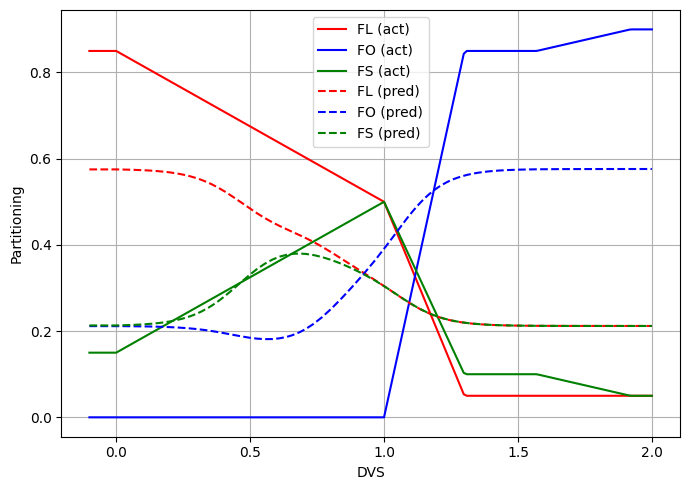

In [12]:
# ---- compare the results with test data ----
plt.figure(figsize=(7, 5))

dvs = torch.tensor([float(item["DVS"]) for item in external_states], dtype=torch.float32)

# Actual (dashed)
fl, fo, fs = expected_results[0, :, 0], expected_results[0, :, 1], expected_results[0, :, 2]
fltb_act = torch.stack([dvs, fl], dim=1).flatten()
fotb_act = torch.stack([dvs, fo], dim=1).flatten()
fstb_act = torch.stack([dvs, fs], dim=1).flatten()

plot_xy_table(fltb_act, label="FL (act)", color="r", linestyle="-")
plot_xy_table(fotb_act, label="FO (act)", color="b", linestyle="-")
plot_xy_table(fstb_act, label="FS (act)", color="g", linestyle="-")

# predicted (solid)
predictions = results.detach()
fl, fo, fs = predictions[0, :, 0], predictions[0, :, 1], predictions[0, :, 2]
fltb_opt = torch.stack([dvs, fl], dim=1).flatten()
fotb_opt = torch.stack([dvs, fo], dim=1).flatten()
fstb_opt = torch.stack([dvs, fs], dim=1).flatten()
plot_xy_table(fltb_opt, label="FL (pred)", color="r", linestyle="--")
plot_xy_table(fotb_opt, label="FO (pred)", color="b", linestyle="--")
plot_xy_table(fstb_opt, label="FS (pred)", color="g", linestyle="--")

plt.xlabel("DVS")
plt.ylabel("Partitioning")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

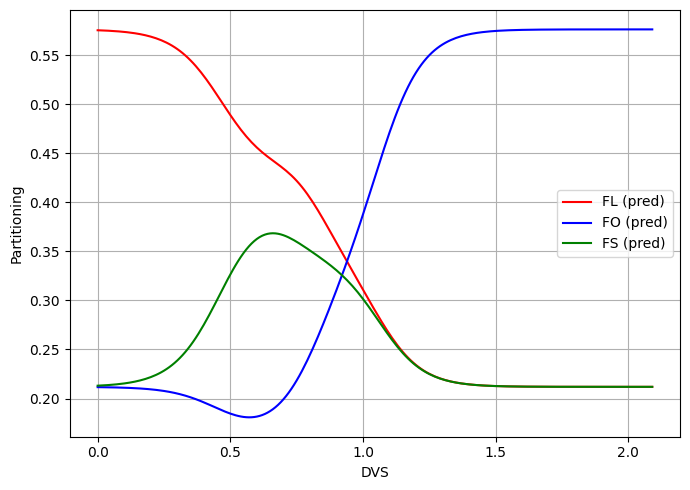

In [13]:
# ---- tables ----
with torch.no_grad():
    fltb_opt, fotb_opt, fstb_opt = opt_model.get_tables()

plt.figure(figsize=(7, 5))

# Optimized (solid)
plot_xy_table(fltb_opt, label="FL (pred)", color="r")
plot_xy_table(fotb_opt, label="FO (pred)", color="b")
plot_xy_table(fstb_opt, label="FS (pred)", color="g")

plt.xlabel("DVS")
plt.ylabel("Partitioning")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()